# Final Report: 06/19/2019

## Brief: What was done previously
Previous work discovered multiple mechanisms to improve the accuracy of prediction. Here we quantify the performance of those methods and test them against a standard baseline. Additionally, we quantify learned model's resistence to noise and missing observations.

## Hypothesis

1. Hypothesis 1: Deep recurrent networks are tolerant of sensor noise below a certain magnitude (fixed gaussians per pixel noise)
2. Hypothesis 2: Deep recurrent networks are tolerant of missing samples (random per pixel dropout)
3. Hypothesis 3: Deep recurrent networks out perform standard baselines and pevious models



## Summary of Main Results and Discussions
Discovered deep recurrent neural networks are capable of learning distributions well even given noisy observations or missing samples, with small amounts of noise and missing samples even improving network generalization. 

Learned deep recurrent networks significantly out perform standard linear models as well as previous non-recurrent neual network aproaches


### Hypothesis 1 results and discussion
Leaned models handle noise suppression impresivly well, dealing with noise with standard deviation twice as large as the range of the sample data. 

### Experiment 2: results and discussion
Put main result and conclusions here. Discuss importance/impact in terms of the project goals.


## Plan for next effort
What will be tested/extended from this week?
Future extention should test 
    

    


In [1]:
# import packages 
import importlib
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import os

# Hypothesis 1

Deep recurrent networks are tolerant to sensor noise below a certain magnitude

## Measure accuracy over increasing fixed gaussian sensor noise
We add increasing magnitudes of gaussian noise to the input and predict the clean original signal. We expect, for
high levels of noise, the model to over-fit to the noise. However, after some threshold we expect the model to learn to recover from small perturbations by learning the underlying distribution.

In [1]:
# Gaussian noise study (fixed input noise)
import numpy as np
import tensorflow as tf

from src.predict_turbulence_recurrent import train
from src.dataLoader.turbulence import Turbulence, RANDOM_SEED, LARGE_DATASET

# Use a fixed seed for noise    
np.random.seed(RANDOM_SEED)

for s in [2, 1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.0001, 0]:
    noise_data = np.random.normal(size=(360, 279, 1000), scale=scale)
    
    loader = Turbulence(pred_length=20, dataset_idx=LARGE_DATASET, input_noise=noise_data, debug=False)
    
    train(loader=loader, dataset_idx=LARGE_DATASET, num_batches=100000, net_name='lstm_3_cells_20_static_noise_{}'.format(scale))
    
    tf.reset_default_graph()


C:\Users\brandon\source\orbitalMechanics
Instructions for updating:
Colocations handled automatically by placer.
Input shape: (20, ?, 2500)
Output shape: (20, ?, 50, 50)
Encoder input shape: [20, None, 2500]
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Padded input shape: [20, 64, 2500]
[20, 64, 250]
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Summary name Loss Histogram is illegal; using Loss_Histogram instead.
INFO:tensorflow:Summary name Mean Abs Error is illegal; using Mean_Abs_Error instead.
( 0.283889 0 )
( 0.008285959 500 )
0.0033416222 1000
0.

## Explore results - Hypothesis 1

In this test given a 3 layer encoder/decoder model with 250 units per layer, we see that the performance of the model is 
resistant to up to 5% noise without any degradation. Futher noise causes significant increases in L2 loss porportinal to the magnitude of of noise. 

In [8]:
# Compare accuracy of model with increasing fixed noise
import os
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio
import plotly


plotly.offline.init_notebook_mode(connected=True)
plt.rc('text', usetex=True)
    
# Compare MSE vs magnitude of noise
noise = [2, 1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.0001, 0]
noise.reverse()
train_accuracy = [1.836e-5, 1.8441e-5, 2.0871e-5, 2.0525e-5, 2.0918e-5, 2.2431e-5, 2.2850e-5, 3.6688e-5, 6.5500e-5, 7.1376e-5, 7.3004e-5, 7.1560e-5, 1.1372e-4]
validation_accuracy = [1.932e-5, 1.9536e-5, 2.1711e-5, 2.1794e-5, 2.1213e-5, 2.3923e-5, 2.4532e-5, 4.2984e-5, 1.0194e-4, 2.9481e-4, 5.4323e-4, 7.5883e-4, 2.0583e-3]

# Create a trace
trace1 = go.Scatter(
    x = noise,
    y = validation_accuracy,
    name="validation"
)
trace2 = go.Scatter(
    x = noise,
    y = train_accuracy,
    name="train"
)

data = [trace1]
layout = go.Layout(
    title="Magnitude of Sensor Noise vs L2 Loss",
    xaxis=dict(
        type='log',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Standard Deviation of Added Gaussian Noise',
    ),
    yaxis=dict(
        type='log',
        tickmode = 'array',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Mean Squared Validation Error n=20',
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='static_noise_model')



In [9]:
data = [trace1, trace2]
layout = go.Layout(
    title="Magnitude of Sensor Noise vs L2 Loss",
    xaxis=dict(
        type='log',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Standard Deviation of Added Gaussian Noise',
    ),
    yaxis=dict(
        type='log',
        tickmode = 'array',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Mean Squared Error n = 20',
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='static_noise_model_comparison')

In [10]:
# Accuracy over time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

exp_root = './experiments/turbulence/recurrent_scaled_mse'
exp_folders = ['lstm_3_cells_p20_static_noise_{}_velocity_and_vorticity_field_1200s.mat_lr0.0005'.format(n) for n in noise if n != 0.0001]
npys = ['train_accuracy_by_time.npz', 'validation_accuracy_by_time.npz']

train_data = []
validation_data = []
diff = []

for i, directory in enumerate(exp_folders):
    # Load input, prediction and label
    if all([os.path.exists(os.path.join(exp_root, directory, f)) for f in npys]):
        ts = '50000'
        train_acc_dir, valid_acc_dir = [os.path.join(exp_root, directory, f) for f in npys]

        with np.load(train_acc_dir) as train_acc, np.load(valid_acc_dir) as valid_acc:
            train_data.append(
                go.Scatter(
                    x = list(range(train_acc[ts].shape[0])),
                    y = train_acc[ts], 
                    name = 'sigma^2={}'.format(noise[i])))
            validation_data.append(
                go.Scatter(
                    x = list(range(valid_acc[ts].shape[0])),
                    y = valid_acc[ts], 
                    name = 'sigma^2={}'.format(noise[i])))
            diff.append(
                go.Scatter(
                    x = list(range(valid_acc[ts].shape[0])),
                    y = valid_acc[ts] - train_acc[ts], 
                    name = 'sigma^2={}'.format(noise[i])))
    else:
        print('skipped', directory)
            
layout = go.Layout(
    title="Prediction Accuracy by Time Horizon - Train",
    xaxis=dict(
        type='linear',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Predicted time step, t',
    ),
    yaxis=dict(
        type='linear',
        tickmode = 'array',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Mean squared validation error n = 20',
    )
)
    
fig = go.Figure(data=train_data, layout=layout)
py.iplot(fig, filename='acc_over_time_noise_study_train')



skipped lstm_3_cells_p20_static_noise_0.75_velocity_and_vorticity_field_1200s.mat_lr0.0005
skipped lstm_3_cells_p20_static_noise_1_velocity_and_vorticity_field_1200s.mat_lr0.0005
skipped lstm_3_cells_p20_static_noise_2_velocity_and_vorticity_field_1200s.mat_lr0.0005


In [11]:
layout = go.Layout(
    title="Prediction Accuracy by Time Horizon - Validation",
    xaxis=dict(
        type='linear',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Predicted time step, t',
    ),
    yaxis=dict(
        type='linear',
        tickmode = 'array',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Mean squared validation error n = 20',
    )
)
    
fig = go.Figure(data=validation_data, layout=layout)
py.iplot(fig, filename='acc_over_time_noise_study_validation')

In [12]:
layout = go.Layout(
    title="Prediction Accuracy by Time Horizon - Difference",
    xaxis=dict(
        type='linear',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Predicted time step, t',
    ),
    yaxis=dict(
        type='linear',
        tickmode = 'array',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Diffrence in MSE between train and validation; n = 20',
    )
)
    
fig = go.Figure(data=diff, layout=layout)
py.iplot(fig, filename='acc_over_time_noise_study_diff')

In [13]:
# Small magnitude of fixed noise increases generalization to new samples
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

exp_root = './experiments/turbulence/recurrent_scaled_mse'
exp_folders = ['lstm_3_cells_p20_static_noise_{}_velocity_and_vorticity_field_1200s.mat_lr0.0005'.format(n) for n in noise if n != 0.0001]
npys = ['train_accuracy_by_time.npz', 'validation_accuracy_by_time.npz']

train = []
validation = []
x = []


for i, directory in enumerate(exp_folders):
    # Load input, prediction and label
    if all([os.path.exists(os.path.join(exp_root, directory, f)) for f in npys]):
        ts = '50000'
        train_acc_dir, valid_acc_dir = [os.path.join(exp_root, directory, f) for f in npys]

        with np.load(train_acc_dir) as train_acc, np.load(valid_acc_dir) as valid_acc:
            train.append(train_acc[ts][19]) 
            validation.append(valid_acc[ts][19])
            x.append(noise[i] + 0.0001)
            
train_data = go.Scatter(
        x = x,
        y = train, 
        name = 'train',
        text=[str(p - 0.0001) for p in x])
validation_data = go.Scatter(
        x = x,
        y = validation, 
        name = 'validation',
        text=[str(p - 0.0001) for p in x])
            
layout = go.Layout(
    title="Sensor noise vs prediction error at step t+20",
    xaxis=dict(
        type='linear',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Standard deviation of added fixed gaussian noise',
    ),
    yaxis=dict(
        type='linear',
        tickmode = 'array',
        autorange=True,
        showexponent = 'all',
        exponentformat = 'e',
        title='Mean squared validation error at step t+20',
    )
)
data=[validation_data]
    
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='acc_over_time_noise_study_train')


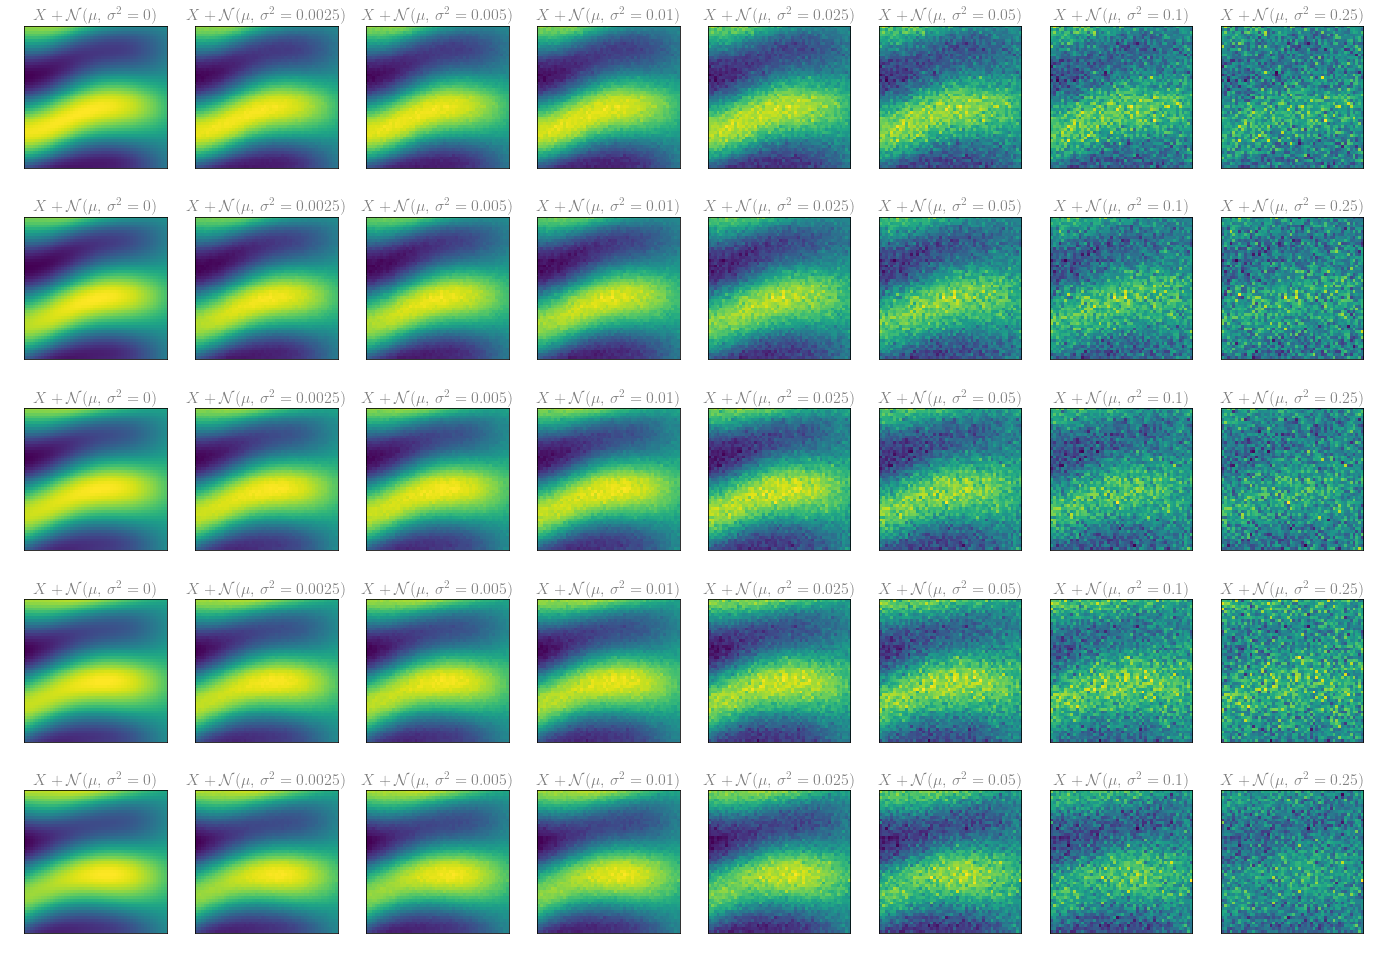

In [14]:
# Visualize noise data
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Make sub-plots for input sequence
plt.rc('text', usetex=True)
fig, plots = plt.subplots(5, 8, figsize=(24, 17))

exp_root = './experiments/turbulence/recurrent_scaled_mse'
exp_folders = ['lstm_3_cells_20_static_noise_{}_velocity_and_vorticity_field_1200s.mat_lr0.0005'.format(n) for n in noise if n != 0.0001]
titles = ['Sequence + N $\sig = {} \mu = 0$'.format(n) for n in noise if n != 0.0001]
titles = [r"$X + \mathcal{N}(\mu,\,\sigma^{2}=" + str(n) + ") $" for n in noise if n != 0.0001]

for j in range(5):
    for i, directory in enumerate(exp_folders[:8]):
        for file in os.listdir(os.path.join(exp_root, directory)):
            if file.endswith('.npz') and file.startswith('inputs'):
                file_path = os.path.join(exp_root, directory, file)
                with np.load(file_path) as foo:
                    plots[j, i].imshow(np.reshape(foo['100000'][j*4, 0,:], (50,50)))
                    plots[j, i].set_title(titles[i], fontsize=16, color='gray')
    
for ax in fig.get_axes():
    ax.label_outer()
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
        
plt.show()

                
                



In [14]:
# Make videos of label, prediction, and difference
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Video parameters
fps = 10
height, width = 50, 50
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')

# Convert [0, 1] np.float32 to [0, 255] RGB cv2.uint8
cmap = plt.get_cmap('jet')
def convert_img(img):
    mapped = cmap(img)
    return cv2.normalize(mapped[:,:,:3], None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

def add_lables(img):
    font = cv2.FONT_HERSHEY_TRIPLEX 
    cv2.putText(img,'X',(10,40), font, 0.4,(0,0,0), 2, cv2.LINE_AA)
    cv2.putText(img,'f(X)',(10,90), font, 0.4,(0,0,0), 2, cv2.LINE_AA)
    cv2.putText(img,'Y',(10,140), font, 0.4,(0,0,0), 2, cv2.LINE_AA)
    cv2.putText(img,'|f(x) - y|^2', (10,190), font, 0.4,(0,0,0), 2, cv2.LINE_AA)
    cv2.putText(img,'X',(10,40), font, 0.4,(255,255,255), 1, cv2.LINE_AA)
    cv2.putText(img,'f(X)',(10,90), font, 0.4,(255,255,255), 1, cv2.LINE_AA)
    cv2.putText(img,'Y',(10,140), font, 0.4,(255,255,255), 1, cv2.LINE_AA)
    cv2.putText(img,'|f(x) - y|^2', (10,190), font, 0.4,(255,255,255), 1, cv2.LINE_AA)

# initialize video writer
video_filename = 'output.avi'

noise = [2, 1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.0001, 0]

exp_root = './experiments/turbulence/recurrent_scaled_mse'
exp_folders = ['lstm_3_cells_p20_static_noise_{}_velocity_and_vorticity_field_1200s.mat_lr0.0005'.format(n) for n in noise if n != 0.0001]
titles = ['Sequence + N $\sig = {} \mu = 0$'.format(n) for n in noise if n != 0.0001]
titles = [r"$X + \mathcal{N}(\mu,\,\sigma^{2}=" + str(n) + ") $" for n in noise if n != 0.0001]
npys = ['inputs.npz', 'predictions.npz', 'labels.npz']

for i, directory in enumerate(exp_folders):
    # Load input, prediction and label
    if all([os.path.exists(os.path.join(exp_root, directory, f)) for f in npys]):
        print('rendering video for', directory)
        ts = '10000'
        input_dir, pred_dir, label_dir = [os.path.join(exp_root, directory, f) for f in npys]

        with np.load(input_dir) as inputs, np.load(pred_dir) as predictions, np.load(label_dir) as labels:

            out = cv2.VideoWriter(directory + '.avi', fourcc, fps, (width*16, height*4))

            # First show input sequence
            for i in range(inputs[ts].shape[0]):
                top = np.concatenate(
                        [np.reshape(inputs[ts][i, j,:], (50,50)) for j in range(16)], axis=1)
                mid = np.concatenate(
                        [np.zeros((50, 50), dtype='float32') for _ in range(16)], axis=1)
                bot = np.concatenate(
                        [np.zeros((50, 50), dtype='float32') for _ in range(16)], axis=1)
                end = np.concatenate(
                        [np.zeros((50, 50), dtype='float32') for _ in range(16)], axis=1)
                         
                img = convert_img(np.concatenate([top, mid, bot, end], axis=0))
                add_lables(img)
                print(img.shape)
                out.write(img)
                
            # Then show prediction, label, and diffrence
            for i in range(labels[ts].shape[0]):
                top = np.concatenate(
                        [np.reshape(inputs[ts][19, j,:], (50,50)) for j in range(16)], axis=1)
                mid = np.concatenate(
                        [np.reshape(predictions[ts][i, j,:], (50,50)) for j in range(16)], axis=1)
                bot = np.concatenate(
                        [np.reshape(labels[ts][i, j,:], (50,50)) for j in range(16)], axis=1)
                end = np.concatenate(
                        [2**(np.reshape(predictions[ts][i, j,:], (50,50)) - np.reshape(labels[ts][i, j,:], (50,50))) for j in range(16)], axis=1)
                
                img = convert_img(np.concatenate([top, mid, bot, end], axis=0))
                add_lables(img)
                print(img.shape)
                out.write(img)

            # Now hold the last frame for 20 frames
            for _ in range(20):
                out.write(img)
            
            out.release()
            
    else:
        print('skipped', directory)
print('done')


skipped lstm_3_cells_p20_static_noise_2_velocity_and_vorticity_field_1200s.mat_lr0.0005
skipped lstm_3_cells_p20_static_noise_1_velocity_and_vorticity_field_1200s.mat_lr0.0005
skipped lstm_3_cells_p20_static_noise_0.75_velocity_and_vorticity_field_1200s.mat_lr0.0005
rendering video for lstm_3_cells_p20_static_noise_0.5_velocity_and_vorticity_field_1200s.mat_lr0.0005
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
(200, 800, 3)
rendering video for lstm_3_cells_p20_static_noise_0.25_velocity_and_vor

In [44]:
from IPython.core.display import display, HTML
display(HTML('<h1>Hello, world!</h1>'))

# Hypothesis 2

Deep recurrent networks are tolerant to missing samples 

# Test 1

Train modls with increasing magnitudes of random missing (zeroed) samples and compare their performance


In [1]:
# Missing samples study (random missing pixels)
import numpy as np
import tensorflow as tf

from src.predict_turbulence_recurrent import train
from src.dataLoader.turbulence import Turbulence, RANDOM_SEED, LARGE_DATASET

# Use a fixed seed  
np.random.seed(RANDOM_SEED)

for s in [0.9, 0.75, 0.5, 0.25, 0.1]:
        
    loader = Turbulence(pred_length=20, dataset_idx=LARGE_DATASET, debug=False)
    
    train(loader=loader, dataset_idx=LARGE_DATASET, num_batches=100000, pixel_dropout=s,
          net_name='lstm_3_cells_20_pixel_dropout_{}'.format(s))
    
    tf.reset_default_graph()

C:\Users\brandon\source\orbitalMechanics
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Input shape: (20, ?, 2500)
Output shape: (20, ?, 50, 50)
Encoder input shape: [20, None, 2500]
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Padded input shape: [20, 64, 2500]
[20, 64, 250]
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Summary name Loss Histogram is illegal; using Loss_Histogram instead.
INFO:tensorflow:Summary name Mean Abs Error is illegal; using Mean_Abs_Error ins

KeyboardInterrupt: 

# Baselines
Comparing model perfomance 

In [ ]:
# Best lstm network
import numpy as np
import tensorflow as tf

from src.predict_turbulence_recurrent import train
from src.dataLoader.turbulence import Turbulence, LARGE_DATASET

loader = Turbulence(pred_length=20, dataset_idx=LARGE_DATASET, input_noise=noise_data, debug=False)

train(loader=loader, dataset_idx=LARGE_DATASET, num_batches=100000, net_name='lstm_3_cells_+20_{}'.format(scale))

tf.reset_default_graph()

# Comparing Models

In [41]:
# Make videos of label, prediction, and difference
import cv2

# Video parameters
fps = 8
height, width = 50, 50
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')

# Convert [0, 1] np.float32 to [0, 255] RGB cv2.uint8
cmap = plt.get_cmap('jet')
def convert_img(img):
    mapped = cmap(img)
    return cv2.normalize(mapped[:,:,:3], None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


# initialize video writer
video_filename = 'output.avi'



exp_root = './experiments/turbulence/recurrent_scaled_mse'
exp_folders = ['gru_5_cells_p20_static_noise_0_velocity_and_vorticity_field_1200s.mat_lr0.0001']
npys = ['inputs.npz', 'predictions.npz', 'labels.npz']

for i, directory in enumerate(exp_folders):
    # Load input, prediction and label
    if all([os.path.exists(os.path.join(exp_root, directory, f)) for f in npys]):
        print('done')
        ts = '10000'
        input_dir, pred_dir, label_dir = [os.path.join(exp_root, directory, f) for f in npys]

        with np.load(input_dir) as inputs, np.load(pred_dir) as predictions, np.load(label_dir) as labels:

            out = cv2.VideoWriter(video_filename, fourcc, fps, (width, height*4))

            # First show input sequence
            for i in range(inputs[ts].shape[0]):
                top = convert_img(np.reshape(inputs[ts][i, 0,:], (50,50)))
                mid = np.zeros((50, 50, 3), dtype='uint8')
                bot = np.zeros((50, 50, 3), dtype='uint8')
                dif = np.zeros((50, 50, 3), dtype='uint8')
                print(np.concatenate([top, mid, bot, dif], axis=0).shape)
                out.write(np.concatenate([top, mid, bot, dif], axis=0))
                
            # Then show prediction and label
            for i in range(labels[ts].shape[0]):
                top = convert_img(np.reshape(inputs[ts][19, 0,:], (50,50)))
                mid = convert_img(np.reshape(predictions[ts][i, 0,:], (50,50)))
                bot = convert_img(np.reshape(labels[ts][i, 0,:], (50,50)))
                dif = convert_img(10*2**(np.reshape(predictions[ts][i, 0,:], (50,50)) - np.reshape(labels[ts][i, 0,:], (50,50))))
                print(np.concatenate([top, mid, bot, dif], axis=0).shape)
                out.write(np.concatenate([top, mid, bot, dif], axis=0))
                
            # Then hold last image
            for i in range(10):
                out.write(np.concatenate([top, mid, bot, dif], axis=0))

            # Now hold the last frame and show label and prediction beneth
            out.release()
            break
print('done')

done
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
(200, 50, 3)
done


### LSTM 3 cell 